# Project Kojak
Kenny Leung - kenleung11@gmail.com 

Part 1/1 - Classification model for predicting a building's architectural style based on images. 

This notebook documents the process of image preprocessing, training of a convolution neural network using transfer learning, training of a variational autoencoder and using t-SNE for data visualization. Data are Google images.

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Lambda, Layer
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
from keras import metrics

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.style as style
from skimage import io
from scipy.stats import norm

%matplotlib inline

In [ ]:
import cv2
import glob
import random
import numpy as np
import pandas as pd
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [ ]:
style.use('fivethirtyeight')

# Load The Image Data Functions

In [ ]:
def rotateImage(img, angle):
    '''
    This function performs random rotations on an image.
    '''
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols,rows))

def loadBlurImg(path, imgSize):
    '''
    This function loads the image from a path and blurs the image.
    
    Args:
        path: path to jpeg on local disk
        imgSize: Tuple of image size
        
    Returns:
        Numpy array of the input image.
    '''
    img = cv2.imread(path)
    angle = np.random.randint(0, 360)
    img = rotateImage(img, angle)
    img = cv2.blur(img,(5,5))
    img = cv2.resize(img, imgSize)
    return img

def loadImgClass(classPath, classLable, classSize, imgSize):
    '''
    This function reads the images in the path and sets the class label.
    
    Args:
        classPath: List of path to all the images in the class.
        classLable: Class label
        classSize: number of images per class in train set
        imgSize: Tuple of image size
        
    Returns:
        List of numpy arrays of the input images and the class label
    '''
    x = []
    y = []
    
    for path in classPath:
        img = loadBlurImg(path, imgSize)        
        x.append(img)
        y.append(classLable)
        
    while len(x) < classSize:
        randIdx = np.random.randint(0, len(classPath))
        img = loadBlurImg(classPath[randIdx], imgSize)
        x.append(img)
        y.append(classLable)
        
    return x, y

def loadTestClass(classPath, classLable, img_size):
    '''
    This function reads the images in the path and sets the class label.
    
    Args:
        classPath: List of path to all the images in the class.
        classLable: Class label
        img_size: integer of image size
        
    Returns:
        List of numpy arrays of the input images and the class label
    '''
    x = []
    y = []
    
    for path in classPath:
        img = loadImage(img_size, path)[0]
        x.append(img)
        y.append(classLable)
        
    return x, y

def TrainTestSplit(style_path,num_of_test):
    '''
    This function randomly splits the images in the path into train set and test set.
    
    Arg:
        style_path: Path of all images of a particular architectural style
        num_of_test: Integer of number of images in the test set.
        
    Return:
        Lists of paths for the training and test set for images for a particular architectural style.
    '''
    X_test_path = random.sample(style_path, num_of_test)
    X_train_path = [x for x in style_path if x not in X_test_path]
    
    return X_train_path, X_test_path
    
def loadData(styles,size,classSize):
    '''
    This function loads all images, augments images, and splits into train set and test set.
    
    Args:
        styles: List of different architectural styles for classification.
        size: integer of image size
        classSize: number of images per class in train set
        
    Returns:
        Numpy arrays of training and test sets and path of image to test set.
    '''
    d = {}
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    y_test_path = []

    imgSize = (size,size) 
    for style in styles:
        # reads all images in directory
        d['{}'.format(style)] = glob.glob('/home/ec2-user/data/{}/*.jpg'.format(style)) 
        
        # splits all paths in the directory of a particular style into a train and test set
        d['{}_train'.format(style)],d['{}_test'.format(style)]  = TrainTestSplit(d[style],num_of_test)
        
        # read the images in the test images path and assigns a label
        d['x_test_{}'.format(style)], d['y_test_{}'.format(style)] = loadTestClass(d['{}_test'.format(style)], 
                                                                                   styles.index(style),
        # read the images in the train images path and assigns a label                                                                                   size)
        d['x_train_{}'.format(style)], d['y_train_{}'.format(style)] = loadImgClass(d['{}_train'.format(style)],
                                                                                  styles.index(style),
                                                                                  classSize,
                                                                                  imgSize)
        print("There are", len(d['x_train_{}'.format(style)]), \
              "{} train images and".format(style), \
              len(d['x_test_{}'.format(style)]), "test images")
        
        X_train += (d['x_train_{}'.format(style)])
        y_train += (d['y_train_{}'.format(style)])
        X_test += (d['x_test_{}'.format(style)])
        y_test += (d['y_test_{}'.format(style)])
        y_test_path += (d['{}_test'.format(style)])
    
    # turn the lists into numpy arrays                                                                               
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # pickle the numpy arrays                                                                               
    joblib.dump(X_train, 'X_train.pkl')
    joblib.dump(y_train, 'y_train.pkl')
    joblib.dump(X_test, 'X_test.pkl')
    joblib.dump(y_test, 'y_test.pkl')
    joblib.dump(y_test_path, 'y_test_path.pkl')
            
    return X_train, X_test, y_train, y_test, y_test_path

def loadImage(img_size, path):
    '''
    This function loads a jpg and returns a numpy array.
    
    Args:
        img_size: integer of image size
        path: path to jpeg on local disk
        
    Returns:
        Numpy array of input image
    '''
    imgSize = (img_size, img_size)
    img = cv2.imread(path) # reads jpeg using openCV
    img = cv2.resize(img, imgSize) # resizes the image to (256,256)
    
    return np.array([img])

# Loading of the Data

In [5]:
# image size
size = 256

# number of images per class in train set
classSize = 10000

# number of images per class in test set
num_of_test = 100

# list of architectural styles
styles = ['art_deco','art_nouveau','chinese','gothic','modernist','neoclassicism','renaissance','romanesque','russian']

In [6]:
# # making sure all images load properly
# style = 'russian'
# style = glob.glob('/home/ec2-user/data/{}/*.jpg'.format(style))
# print(len(style))
# imgSize = (size,size)

# for path in style:
#     print(path)
#     img = loadBlurImg(path, imgSize)

In [ ]:
# %%time
# X_train, X_test, y_train, y_test, y_test_path = loadData(styles,size,classSize)

In [6]:
%%time
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')
X_train = joblib.load('X_train.pkl')
X_test = joblib.load('X_test.pkl')
y_test_path = joblib.load('y_test_path.pkl')

CPU times: user 3.78 s, sys: 10.8 s, total: 14.6 s
Wall time: 3min 9s


In [8]:
# number of classes
n_classes = len(np.unique(y_train))

from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
print("Number of classes =", n_classes)
print("train shape X", X_train.shape)
print("train shape y", y_train.shape)
print("test shape X", X_test.shape)
print("test shape y", y_test.shape)

Number of classes = 9
train shape X (90000, 256, 256, 3)
train shape y (90000, 9)
test shape X (900, 256, 256, 3)
test shape y (900, 9)


# Fine-tune InceptionV3 on a new set of classes

https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes <br>
sudo pip install h5py <br>
https://blog.keras.io/building-autoencoders-in-keras.html

In [12]:
%%time
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', input_shape=(size,size,3), include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a fully-connected layer
x = Dense(500, activation='relu')(x)
# add dropout layer
x = Dropout(0.5)(x)
# add a fully-connected layer
x = Dense(100, activation='relu')(x)
# and a logistic layer
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# freeze the first 248 convolutional InceptionV3 layers
for layer in base_model.layers[:249]:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

CPU times: user 13.9 s, sys: 196 ms, total: 14.1 s
Wall time: 15.6 s


https://keras.io/callbacks/

In [8]:
%%time
# define the checkpoint, monitor validation loss
filepath="weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
callbacks_list = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto'),
                  ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30.8 µs


In [ ]:
%%time
# train the model on the new data
model.fit(X_train,y_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_split=0.1)

In [ ]:
# save the loss and validation loss values to plot
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

In [ ]:
joblib.dump(loss, 'loss_dropout_50_batch_size_32.pkl')
joblib.dump(val_loss, 'val_loss_dropout_50_batch_size_32.pkl')

In [ ]:
# plots the loss and validation loss for each epoch
plt.figure(figsize = (10,6))

plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss (dropout = 0.5, batch_size = 32, patience = 10)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Load the Network Weights

In [ ]:
# %%time
# model.load_weights('weights-improvement-02-0.8015.hdf5')

In [ ]:
# %%time
# # train the model on the new data
# model.fit(X_train,y_train, epochs=100, batch_size=64, callbacks=callbacks_list, validation_split=0.1)

# Classification Metrics

## Top-3 Accuracy

In [10]:
def get_top_styles(prediction,num_top):
    '''
    This function returns the top N styles and predictions.
    
    Args:
        prediction: results of model.predict
        num_top: Integer of number of top predictions per image.
        
    Returns:
        Index of the top predictions, top predictions, and values of top predictions
    '''
    top_indices = []
    top_styles = []
    top_preds = []

    for pred in prediction:
        pred_list = list(enumerate(pred))
        pred_list.sort(key=lambda x: x[1],reverse=True) # sort predictions from highest to lowest
        top = pred_list[:num_top]

        top_index = [x[0] for x in top]
        top_style = [styles[x[0]] for x in top]
        top_pred = [x[1] for x in top]

        top_indices.append(top_index)
        top_styles.append(top_style)
        top_preds.append(top_pred)
    
    return top_indices, top_styles, top_preds

def get_actuals(y_test):
    '''
    This function gets the actual architectural style of the test set.
    '''
    actuals = []
    for img in y_test:
        actuals.append(np.argmax(img))
    
    return actuals
        
def get_accuracy(y_test,prediction,num_top):
    '''
    This function prints the top N accuracy.
    
    Args:
        y_test: Labels of the test set.
        prediction: results of model.predict
        num_top: Integer of number of top predictions per image.
    '''
    actuals = get_actuals(y_test)
    top_indices, top_styles, top_preds = get_top_styles(prediction,num_top)
    
    in_top = 0
    for i in list(zip(actuals, top_indices)):
        if i[0] in i[1]:
            in_top += 1
    
    print('Top {} accuracy: {:0.2f}%'.format(num_top,100*in_top/len(actuals)))
    
def bad_path(y_test,prediction,num_top,y_test_path):
    '''
    This function gets information on the images that were not predicted in the top-N classes.
    
    Args:
        y_test: Labels of the test set.
        prediction: results of model.predict
        num_top: Integer of number of top predictions per image.
        y_test_path: The image path for the test images.
        
    Returns:
        Actual labels, indices, predictions and paths of the images that were not predicted in the top-N classes.
    '''
    actuals = get_actuals(y_test)        
    top_indices, top_styles, top_preds = get_top_styles(prediction,num_top)
    
    bad_actuals = []
    bad_indices = []
    bad_styles = []
    bad_preds = []
    bad_paths = []
    
    for i in list(zip(actuals, top_indices, top_styles, top_preds, y_test_path)):
        if i[0] not in i[1]:
            bad_actuals.append(i[0])
            bad_indices.append(i[1])
            bad_styles.append(i[2])
            bad_preds.append(i[3])
            bad_paths.append(i[4])
            
    return bad_actuals, bad_indices, bad_styles, bad_preds, bad_paths

def good_path(y_test,prediction,num_top,y_test_path):
    '''
    This function gets information on the images that were predicted in the top-N classes.
    
    Args:
        y_test: Labels of the test set.
        prediction: results of model.predict
        num_top: Integer of number of top predictions per image.
        y_test_path: The image path for the test images.
        
    Returns:
        Actual labels, indices, predictions and paths of the images that were predicted in the top-N classes.
    '''
    actuals = get_actuals(y_test)        
    top_indices, top_styles, top_preds = get_top_styles(prediction,num_top)
    
    good_actuals = []
    good_indices = []
    good_styles = []
    good_preds = []
    good_paths = []
    
    for i in list(zip(actuals, top_indices, top_styles, top_preds, y_test_path)):
        if i[0] in i[1]:
            good_actuals.append(i[0])
            good_indices.append(i[1])
            good_styles.append(i[2])
            good_preds.append(i[3])
            good_paths.append(i[4])
            
    return good_actuals, good_indices, good_styles, good_preds, good_paths

In [11]:
# weights-improvement-04-1.0839.hdf5 - dropout 0.2, patience 3, batch size 64
# weights-improvement-03-0.9686.hdf5 - dropout 0.5, patience 5, batch size 128
# weights-improvement-06-1.1096.hdf5 - dropout 0.5, patience 10, batch size 32

In [13]:
model.load_weights('weights-improvement-03-0.9686.hdf5')

In [28]:
model.save('/home/ec2-user/notebook/model')

In [14]:
prediction = model.predict(X_test)
get_accuracy(y_test,prediction,3)
get_accuracy(y_test,prediction,2)
get_accuracy(y_test,prediction,1)

Top 3 accuracy: 95.11%
Top 2 accuracy: 91.67%
Top 1 accuracy: 80.89%


## Absolute Accuracy

In [15]:
def get_metrics(X_test,y_test):
    '''
    This function prints the classification metrics of the test set.
    '''
    prediction = model.predict(X_test)

    metrics = model.evaluate(X_test, y_test)
    metric_name = model.metrics_names[0]
    print('{}: {}'.format(metric_name, metrics))

    predictions = []
    for img in prediction:
        predictions.append(np.argmax(img))

    actuals = []
    for img in y_test:
        actuals.append(np.argmax(img))

    print('accuracy: {0:.5}'.format(accuracy_score(actuals, predictions)))
    print('precision: {0:.5}'.format(precision_score(actuals, predictions,average='macro')))
    print('recall: {0:.5}'.format(recall_score(actuals, predictions,average='macro')))
    print('f1: {0:.5}'.format(f1_score(actuals, predictions,average='macro')))

    print('confusion matrix:')
    print('\n')
    print(confusion_matrix(actuals,predictions))

In [16]:
styles

['art_deco',
 'art_nouveau',
 'chinese',
 'gothic',
 'modernist',
 'neoclassicism',
 'renaissance',
 'romanesque',
 'russian']

In [17]:
%%time
get_metrics(X_test,y_test)

900/900 [==============================] - 9s     
loss: 1.1747552791656926
accuracy: 0.80889
precision: 0.81338
recall: 0.80889
f1: 0.80678
confusion matrix:


[[85  3  0  0  4  4  1  2  1]
 [ 7 89  1  0  1  1  0  0  1]
 [ 1  0 97  0  0  0  1  1  0]
 [ 2  0  1 91  1  1  3  1  0]
 [ 6  2  1  0 87  3  0  1  0]
 [ 7  2  0  2  0 80  3  2  4]
 [ 3  3  1  8  0 19 60  6  0]
 [ 4  2  1 13  2  1  8 67  2]
 [ 2  1  6  3  0  7  7  2 72]]
CPU times: user 19.6 s, sys: 748 ms, total: 20.4 s
Wall time: 19.6 s


# Look at Bad Predictions

In [18]:
num_top = 3

In [19]:
bad_actuals, bad_indices, bad_styles, bad_preds, bad_paths = bad_path(y_test, prediction, num_top, y_test_path)

In [20]:
good_actuals, good_indices, good_styles, good_preds, good_paths = good_path(y_test, prediction, num_top, y_test_path)

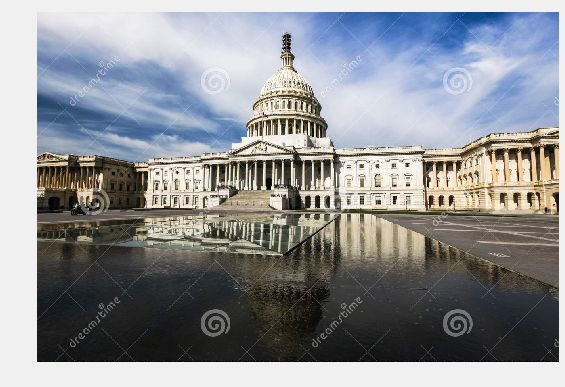

top prediction: ('romanesque', 0.93830585)
second prediction: ('russian', 0.032560486)
third prediction: ('renaissance', 0.019108579)


actual: neoclassicism
path: /home/ec2-user/data/neoclassicism/456a.jpg


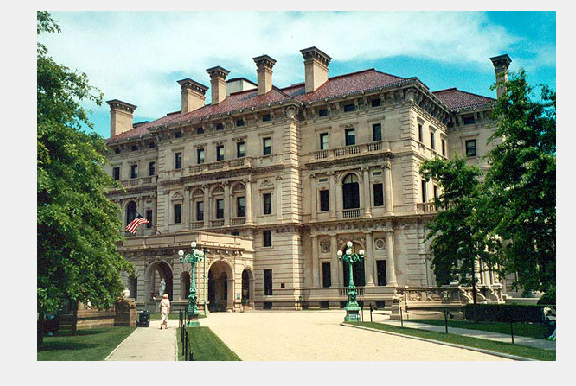

top prediction: ('romanesque', 0.99999988)
second prediction: ('russian', 1.170877e-07)
third prediction: ('renaissance', 3.0106595e-08)


actual: neoclassicism
path: /home/ec2-user/data/neoclassicism/339.jpg


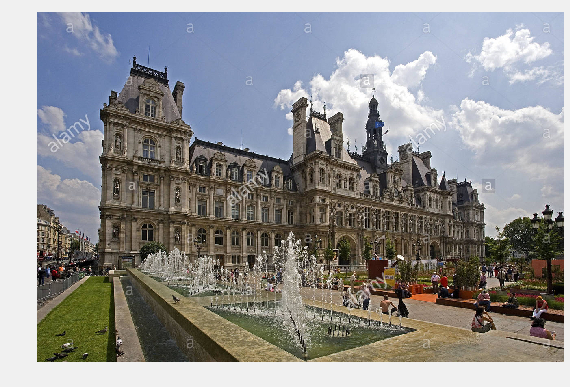

top prediction: ('gothic', 0.99199498)
second prediction: ('renaissance', 0.0079589505)
third prediction: ('romanesque', 4.1933698e-05)


actual: neoclassicism
path: /home/ec2-user/data/neoclassicism/240a.jpg


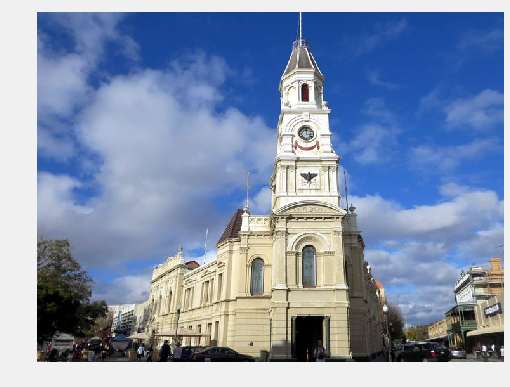

top prediction: ('russian', 0.77401501)
second prediction: ('renaissance', 0.20621198)
third prediction: ('romanesque', 0.01454897)


actual: neoclassicism
path: /home/ec2-user/data/neoclassicism/659.jpg


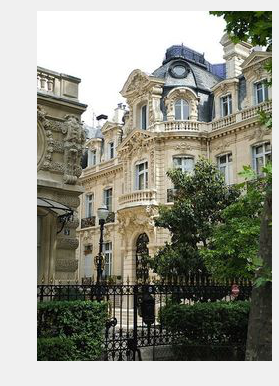

top prediction: ('art_nouveau', 0.99999809)
second prediction: ('romanesque', 1.8588298e-06)
third prediction: ('art_deco', 6.4752537e-09)


actual: renaissance
path: /home/ec2-user/data/renaissance/504.jpg


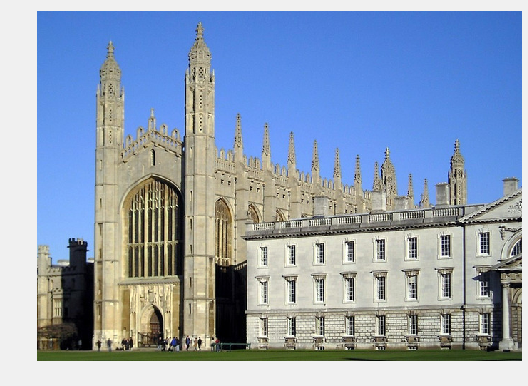

top prediction: ('art_deco', 0.56939691)
second prediction: ('gothic', 0.38499564)
third prediction: ('romanesque', 0.033585913)


actual: renaissance
path: /home/ec2-user/data/renaissance/329.jpg


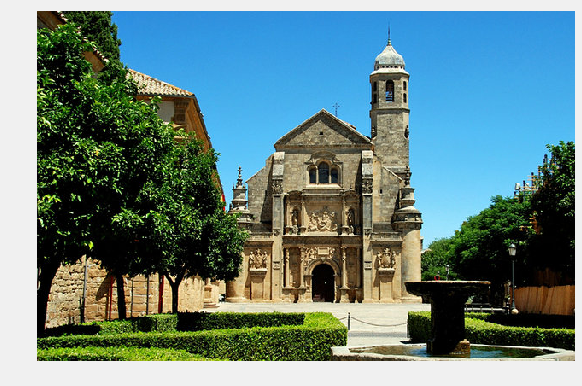

top prediction: ('romanesque', 0.99999976)
second prediction: ('gothic', 1.9694521e-07)
third prediction: ('russian', 3.8735639e-08)


actual: renaissance
path: /home/ec2-user/data/renaissance/457.jpg


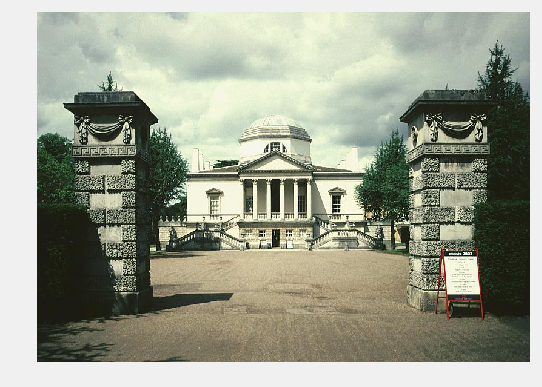

top prediction: ('chinese', 0.9241401)
second prediction: ('russian', 0.026929107)
third prediction: ('neoclassicism', 0.024097905)


actual: renaissance
path: /home/ec2-user/data/renaissance/501.jpg


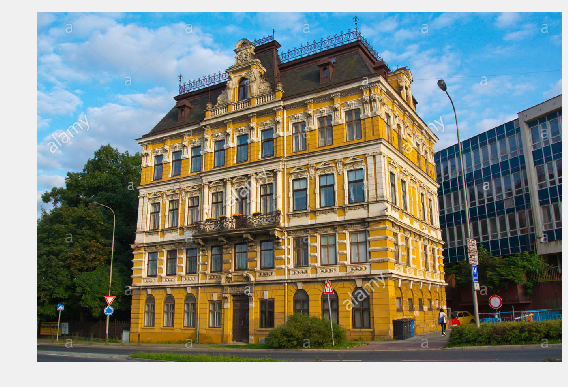

top prediction: ('neoclassicism', 0.7749669)
second prediction: ('russian', 0.11369481)
third prediction: ('romanesque', 0.045351177)


actual: renaissance
path: /home/ec2-user/data/renaissance/400a.jpg


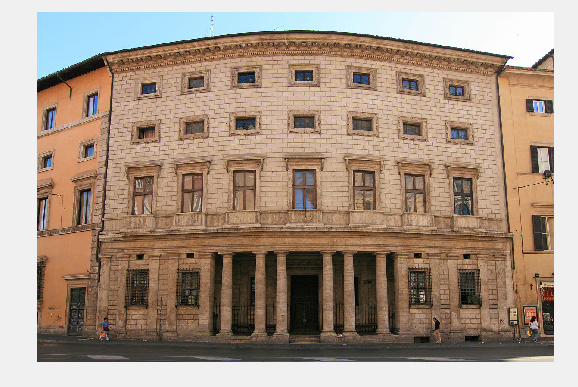

top prediction: ('art_nouveau', 0.52109253)
second prediction: ('art_deco', 0.39143005)
third prediction: ('neoclassicism', 0.02419465)


actual: renaissance
path: /home/ec2-user/data/renaissance/renaissance-palazzo_massimo_alle_colonne.jpg


In [23]:
for index in range(15,25):
    image = cv2.imread(bad_paths[index])

    plt.figure(figsize=(10,6))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    predictions = list(zip(bad_styles[index],bad_preds[index]))
    
    print('top prediction: {}'.format(predictions[0]))
    print('second prediction: {}'.format(predictions[1]))
    print('third prediction: {}'.format(predictions[2]))
    print('\n')
    print('actual: {}'.format(styles[bad_actuals[index]]))
    print('path: {}'.format(bad_paths[index]))

In [ ]:
# Image(bad_paths[index],width=300,height=300)

# Look at Good Predictions

In [ ]:
for index in range(5):
    image = cv2.imread(good_paths[index])

    plt.figure(figsize=(10,6))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    predictions = list(zip(good_styles[index],good_preds[index]))
    
    print('top prediction: {}'.format(predictions[0]))
    print('second prediction: {}'.format(predictions[1]))
    print('third prediction: {}'.format(predictions[2]))
    print('\n')
    print('actual: {}'.format(styles[good_actuals[index]]))
    print('path: {}'.format(good_paths[index]))

# Apply Classifier from Disk

In [24]:
def classifier(path):
    '''
    This function takes in an image from disk and runs a prediction of architectural style.
    '''
    img = loadImage(size, path)
    prediction = model.predict(img)
    top_indices, top_styles, top_preds = get_top_styles(prediction,3)
    
    building = path.split('/')[-1].split('-')[1].split('.')[0].replace('_',' ').title()
    actual = path.split('/')[-1].split('-')[0]
    top_style = top_styles[0][0]
    top_pred = top_preds[0][0]
    second_style = top_styles[0][1]
    second_pred = top_preds[0][1]
    third_style = top_styles[0][2]
    third_pred = top_preds[0][2]
    
    return building, actual, top_style, top_pred, second_style, second_pred, third_style, third_pred

In [ ]:
%%time
paths = glob.glob('/home/ec2-user/data/famous_buildings/*.jpg')

dicts = []
for path in paths:
    d = {}
    
    d['building'], d['actual_style'],\
    d['top_style'], d['top_pred'],\
    d['second_style'], d['second_pred'],\
    d['third_style'], d['third_pred'] = classifier(path)
    d['path'] = path
    
    dicts.append(d)
    
df = pd.DataFrame(dicts,columns=['building','actual_style','top_style','top_pred','second_style','second_pred',
                                 'third_style','third_pred','path'])

In [ ]:
for index in range(0,10):
    image = cv2.imread(paths[index])

    plt.figure(figsize=(10,6))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    predictions = list(zip(list(df.iloc[index][['top_style','second_style','third_style']]),
                                           list(df.iloc[index][['top_pred','second_pred','third_pred']])))

    print('top prediction: {}'.format(predictions[0]))
    print('second prediction: {}'.format(predictions[1]))
    print('third prediction: {}'.format(predictions[2]))
    print('\n')
    print('actual: {}'.format(df.iloc[index]['actual_style']))
    print('path: {}'.format(paths[index]))

In [ ]:
%%time
df['actual_index'] = df['actual_style'].apply(lambda x: styles.index(x))

# X_test and y_test for famous buildings
new_y_test = list(df['actual_index'])

new_X_test = []
for path in paths:
    img = loadImage(size, path)[0]
    new_X_test.append(img)

In [ ]:
def get_accuracy2(y_test,prediction,num_top):
    '''
    This function prints the top N accuracy.
    
    Args:
        y_test: Labels of the test set.
        prediction: results of model.predict
        num_top: Integer of number of top predictions per image.
    '''
    top_indices, top_styles, top_preds = get_top_styles(prediction,num_top)
    
    in_top = 0
    for i in list(zip(y_test, top_indices)):
        if i[0] in i[1]:
            in_top += 1
    
    print('Top {} accuracy: {:0.2f}%'.format(num_top,100*in_top/len(y_test)))

def get_metrics2(prediction,y_test):
    '''
    This function prints the classification metrics of the test set.
    '''
    predictions = []
    for img in prediction:
        predictions.append(np.argmax(img))

    print('accuracy: {0:.5}'.format(accuracy_score(y_test, predictions)))
    print('precision: {0:.5}'.format(precision_score(y_test, predictions,average='macro')))
    print('recall: {0:.5}'.format(recall_score(y_test, predictions,average='macro')))
    print('f1: {0:.5}'.format(f1_score(y_test, predictions,average='macro')))

    print('confusion matrix:')
    print('\n')
    print(confusion_matrix(y_test,predictions))

In [ ]:
%%time
prediction = model.predict(np.array(new_X_test))

get_accuracy2(new_y_test,prediction,3)
get_accuracy2(new_y_test,prediction,2)
get_accuracy2(new_y_test,prediction,1)

In [ ]:
get_metrics2(prediction,new_y_test)

# Variation Auto Encoder (VAE)

https://blog.keras.io/building-autoencoders-in-keras.html <br>
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [12]:
batch_size = 100
original_dim = 1024
latent_dim = 2
intermediate_dim = 256
epochs = 15
epsilon_std = 1.0


x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='intermediate')(x)
z_mean = Dense(latent_dim, name='z-mean')(h)
z_log_var = Dense(latent_dim, name='z-variance')(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

/usr/lib/python3.4/dist-packages/ipykernel_launcher.py:50: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [13]:
# get names of layers in inceptionV3 model
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [14]:
# create new model CNN (vae_model) that is the output of layer 'dense_1' of inceptionV3 model 
layer_name = 'dense_1'
vae_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)

In [ ]:
%%time
# input our images into CNN (vae_model) to output array of dimension 1024
X_test = vae_model.predict(X_test)
X_train = vae_model.predict(X_train)

# apply min max scalar
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

joblib.dump(X_test, 'x_test.pkl')
joblib.dump(X_train, 'x_train.pkl')

In [15]:
%%time
x_train = joblib.load('x_train.pkl')
x_test = joblib.load('x_test.pkl')

CPU times: user 64 ms, sys: 192 ms, total: 256 ms
Wall time: 252 ms


In [16]:
%%time
# train vae model with 1024 dimension array as input
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Train on 90000 samples, validate on 900 samples
Epoch 1/15
90000/90000 [==============================] - 5s - loss: 87.7157 - val_loss: 91.5985
Epoch 2/15
90000/90000 [==============================] - 4s - loss: 67.8897 - val_loss: 88.0412
Epoch 3/15
90000/90000 [==============================] - 4s - loss: 66.2506 - val_loss: 87.3418
Epoch 4/15
90000/90000 [==============================] - 4s - loss: 65.5586 - val_loss: 86.1810
Epoch 5/15
90000/90000 [==============================] - 4s - loss: 65.2242 - val_loss: 85.8862
Epoch 6/15
90000/90000 [==============================] - 4s - loss: 65.0063 - val_loss: 86.1824
Epoch 7/15
90000/90000 [==============================] - 4s - loss: 64.8573 - val_loss: 86.0436
Epoch 8/15
90000/90000 [==============================] - 4s - loss: 64.7659 - val_loss: 85.5265
Epoch 9/15
90000/90000 [==============================] - 4s - loss: 64.6853 - val_loss: 85.3905
Epoch 10/15
90000/90000 [==============================] - 4s - loss: 64.6191 -

In [17]:
loss = vae.history.history['loss']
val_loss = vae.history.history['val_loss']

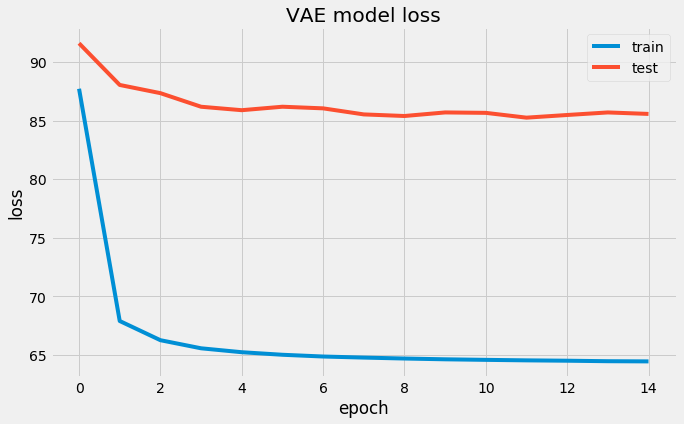

In [18]:
plt.figure(figsize = (10,6))

plt.plot(loss)
plt.plot(val_loss)
plt.title('VAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Reduce Famous Buildings Images to 2-dim and cluster

In [19]:
filename = 'weights-improvement-11-85.2492.hdf5'
vae.load_weights(filename)

In [20]:
for i, layer in enumerate(vae.layers):
    print(i, layer.name)

0 input
1 intermediate
2 z-mean
3 z-variance
4 lambda_1
5 decoder_h
6 decoder_mean
7 custom_variational_layer_1


In [64]:
%%time
# path to famous building pics
paths = glob.glob('/home/ec2-user/data/famous_buildings/*.jpg')

# create data frame
dicts = []
for path in paths:
    d = {}
    
    d['building'], d['actual_style'],\
    d['top_style'], d['top_pred'],\
    d['second_style'], d['second_pred'],\
    d['third_style'], d['third_pred'] = classifier(path)
    d['path'] = path
    
    dicts.append(d)
    
df = pd.DataFrame(dicts,columns=['building','actual_style','top_style','top_pred','second_style','second_pred',
                                 'third_style','third_pred','path'])

new_X_test = []
for path in paths:
    img = loadImage(size, path)[0]
    new_X_test.append(img)
    
# input our famous buildings into CNN (vae_model) to output array of dimension 1024
features = vae_model.predict(np.array(new_X_test))

# apply min max scalar
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

import pickle
scalerfile = 'scaler.sav'
pickle.dump(min_max_scaler, open(scalerfile, 'wb'))

# project famous buildings to 2d latent space
features_2d = encoder.predict(features)

features_x = np.array([x[0] for x in features_2d])
features_y = np.array([x[1] for x in features_2d])

df['vae_x'] = features_x
df['vae_y'] = features_y

vae_df = df[['actual_style','vae_x','vae_y']]

CPU times: user 23 s, sys: 848 ms, total: 23.9 s
Wall time: 22.7 s


In [23]:
# dfs[['building','img']].to_csv('img_paths.csv',index=False)

In [52]:
web_paths = pd.read_csv('img_paths.csv')

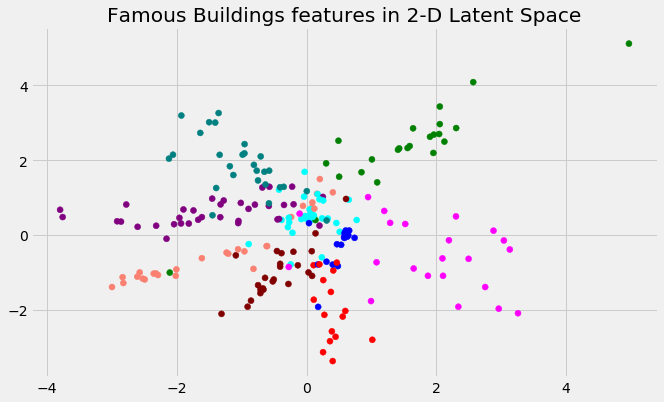

In [53]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {'art_deco':'red', 'art_nouveau':'blue', 'chinese':'green', 'gothic':'teal',
         'modernist':'magenta', 'neoclassicism':'maroon', 'renaissance':'cyan', 'romanesque':'purple', 'russian':'salmon'}

plt.title('Famous Buildings features in 2-D Latent Space')
ax.scatter(vae_df['vae_x'], vae_df['vae_y'], c=vae_df['actual_style'].apply(lambda x: colors[x]));

# t-SNE Visualization

https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b <br>
https://distill.pub/2016/misread-tsne/

In [26]:
%%time
# path to famous building pics
paths = glob.glob('/home/ec2-user/data/famous_buildings/*.jpg')

# create data frame
dicts = []
for path in paths:
    d = {}
    
    d['building'], d['actual_style'],\
    d['top_style'], d['top_pred'],\
    d['second_style'], d['second_pred'],\
    d['third_style'], d['third_pred'] = classifier(path)
    d['path'] = path
    
    dicts.append(d)
    
df = pd.DataFrame(dicts,columns=['building','actual_style','top_style','top_pred','second_style','second_pred',
                                 'third_style','third_pred','path'])

new_X_test = []
for path in paths:
    img = loadImage(size, path)[0]
    new_X_test.append(img)
    
# input our famous buildings into CNN (vae_model) to output array of dimension 1024
features = vae_model.predict(np.array(new_X_test))

# apply min max scalar
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

# apply PCA to reduce 1024 dimensions to 50 dimensions

pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

print('Explained variation: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation: 0.9822826856398024
CPU times: user 22.9 s, sys: 1.17 s, total: 24 s
Wall time: 22.8 s


In [27]:
%%time
# apply t-sne to 50 dimension-space
perplexities = [5,30,50,100]

for i in perplexities:
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=5000)
    tsne_results = tsne.fit_transform(pca_result)

    features_x = np.array([x[0] for x in tsne_results])
    features_y = np.array([x[1] for x in tsne_results])

    df['tsne_x_{}'.format(i)] = features_x
    df['tsne_y_{}'.format(i)] = features_y

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 224 samples in 0.001s...
[t-SNE] Computed neighbors for 224 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 224 / 224
[t-SNE] Mean sigma: 0.624406
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.881126
[t-SNE] Error after 4050 iterations: 0.477228
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 224 samples in 0.000s...
[t-SNE] Computed neighbors for 224 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 224 / 224
[t-SNE] Mean sigma: 1.173893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.044773
[t-SNE] Error after 1450 iterations: 0.350657
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 224 samples in 0.000s...
[t-SNE] Computed neighbors for 224 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 224 / 224
[t-SNE] Mean sigma: 1.399107
[t-SNE] KL divergence after 250 iterations with early e

In [28]:
tsne_df = df[['actual_style','tsne_x_5','tsne_y_5', 'tsne_x_30', 'tsne_y_30', 
              'tsne_x_50','tsne_y_50', 'tsne_x_100', 'tsne_y_100']]

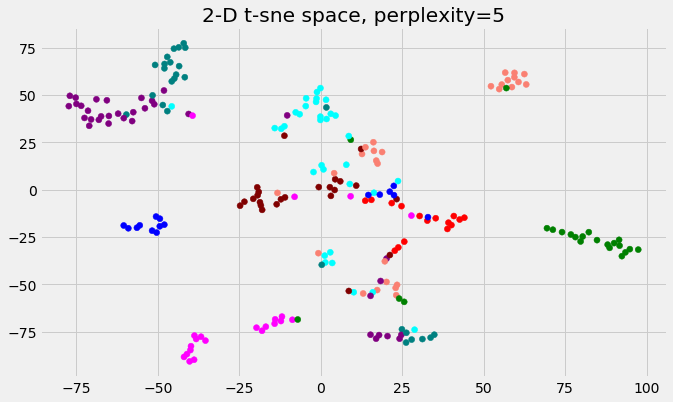

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {'art_deco':'red', 'art_nouveau':'blue', 'chinese':'green', 'gothic':'teal',
         'modernist':'magenta', 'neoclassicism':'maroon', 'renaissance':'cyan', 'romanesque':'purple', 'russian':'salmon'}

plt.title('2-D t-sne space, perplexity=5')
ax.scatter(tsne_df['tsne_x_5'], tsne_df['tsne_y_5'], c=tsne_df['actual_style'].apply(lambda x: colors[x]));

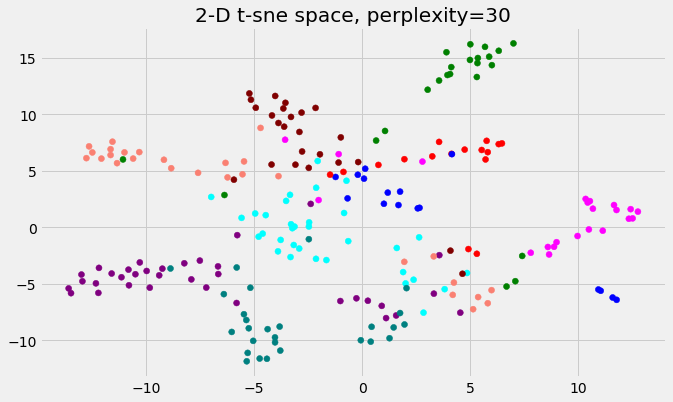

In [30]:
fig, ax = plt.subplots(figsize=(10,6))

plt.title('2-D t-sne space, perplexity=30')
ax.scatter(tsne_df['tsne_x_30'], tsne_df['tsne_y_30'], c=tsne_df['actual_style'].apply(lambda x: colors[x]));

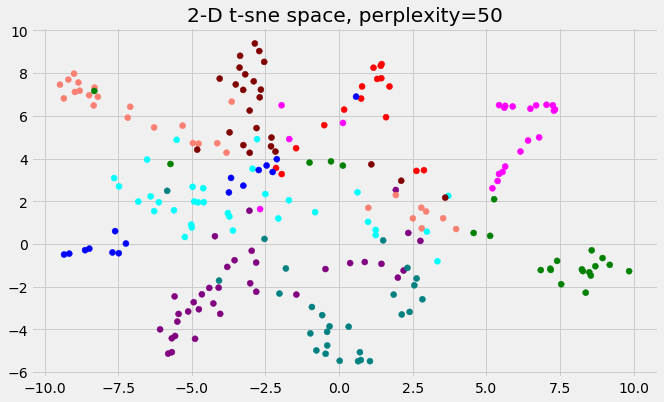

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

plt.title('2-D t-sne space, perplexity=50')
ax.scatter(tsne_df['tsne_x_50'], tsne_df['tsne_y_50'], c=tsne_df['actual_style'].apply(lambda x: colors[x]));

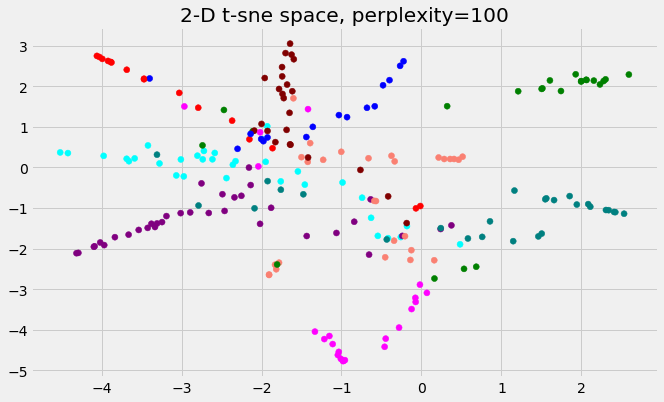

In [32]:
fig, ax = plt.subplots(figsize=(10,6))

plt.title('2-D t-sne space, perplexity=100')
ax.scatter(tsne_df['tsne_x_100'], tsne_df['tsne_y_100'], c=tsne_df['actual_style'].apply(lambda x: colors[x]));

In [33]:
result = pd.concat([web_paths, vae_df, tsne_df], axis=1)

In [49]:
result.head()

building                                                img  \
0  Saint Isaac's Cathedral  https://upload.wikimedia.org/wikipedia/commons...   
1      Tempio Malatestiano  https://upload.wikimedia.org/wikipedia/commons...   
2           Pisa Cathedral  http://www.opapisa.it/wp-content/uploads/2014/...   
3          Los Manantiales  https://images.adsttc.com/media/images/5346/1f...   
4                 Belweder  https://upload.wikimedia.org/wikipedia/commons...   

    actual_style     vae_x     vae_y   actual_style   tsne_x_5   tsne_y_5  \
0        russian  0.081226  0.730723        russian  23.422640 -50.219196   
1    renaissance -0.386868  0.401130    renaissance  -6.467857  39.873177   
2     romanesque -2.922055  0.366989     romanesque -73.502937  44.303814   
3      modernist  3.042835 -0.147453      modernist -40.232006 -90.623047   
4  neoclassicism -0.457337 -0.429770  neoclassicism   4.423565   5.525280   

   tsne_x_30  tsne_y_30  tsne_x_50  tsne_y_50  tsne_x_100  tsne_y_100  
0   5.817545  -6.708994   2.793201   1.699400   -0.138188   -2.277543  
1  -4.606987  -0.548330  -4.999847   0.773606   -2.971776   -0.219266  
2 -13.000355  -4.170206  -5.567364  -4.307690   -4.087258   -1.941348  
3  12.351855   0.768237   7.295589   6.239515   -0.957107   -4.745143  
4  -3.090395   5.554750  -3.248722   4.628376   -1.637138    0.559521

In [35]:
result.to_csv('viz_df.csv',index=False)

# Calculate Euclidean Distances

https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

In [ ]:
layer_name = 'dense_1'
features_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
features = features_model.predict(np.array(new_X_test))

In [ ]:
result = pd.concat([df, pd.DataFrame(features)], axis=1)

In [ ]:
result.head()

In [3]:
def get_similar(path,num_top):
    '''
    This functions takes the image from input URL and calculates closest euclidean distance between famous buildings.
    
    Args:
        path: image URL
        num_top: Integer of number of similar buildings to return.
        
    Returns:
        Displays image and prints predicted and actual labels.
    '''
    image = io.imread(path)
    imgSize = size,size
    img = cv2.resize(image, imgSize).reshape(1,size,size,3)
    input_building = features_model.predict(img)

    prediction = model.predict(img)
    top_indices, top_styles, top_preds = get_top_styles(prediction,3)
    top_style = top_styles[0][0]
    top_pred = top_preds[0][0]
    
    distances = []
    for feature in features:
        dist = np.linalg.norm(input_building-feature)
        distances.append(dist)

    rec_list = list(enumerate(distances))
    rec_list.sort(key=lambda x: x[1],reverse=False)
    top = rec_list[:num_top]

    plt.figure(figsize=(20,8))
    plt.axis("off")
    plt.imshow(image)
    plt.title('Prediction: '+str(top_style).replace('_',' ').title()+' Architecture')

    for i in range(len(top)):
        image = cv2.imread(result.iloc[top[i][0]]['path'])

        plt.figure(figsize=(20,8))
        plt.axis("off")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(str(result.iloc[top[i][0]]['building'])+' -- '+
                  str(result.iloc[top[i][0]]['actual_style']).replace('_',' ').title()+' Architecture'+' -- Distance: '+
                  "{0:.2f}".format(top[i][1]))
        
def get_different(path,num_top):
    '''
    This functions takes the image from input URL and calculates furthest euclidean distance between famous buildings.
    
    Args:
        path: image URL
        num_top: Integer of number of different buildings to return.
        
    Returns:
        Displays image and prints predicted and actual labels.
    '''
    image = io.imread(path)
    imgSize = size,size
    img = cv2.resize(image, imgSize).reshape(1,size,size,3)
    input_building = features_model.predict(img)

    prediction = model.predict(img)
    top_indices, top_styles, top_preds = get_top_styles(prediction,3)
    top_style = top_styles[0][0]
    top_pred = top_preds[0][0]

    distances = []
    for feature in features:
        dist = np.linalg.norm(input_building-feature)
        distances.append(dist)

    rec_list = list(enumerate(distances))
    rec_list.sort(key=lambda x: x[1],reverse=True)
    top = rec_list[:num_top]

    plt.figure(figsize=(20,8))
    plt.axis("off")
    plt.imshow(image)
    plt.title('Prediction: '+str(top_style).replace('_',' ').title()+' Architecture')

    for i in range(len(top)):
        image = cv2.imread(result.iloc[top[i][0]]['path'])

        plt.figure(figsize=(20,8))
        plt.axis("off")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(str(result.iloc[top[i][0]]['building'])+' -- '+
                  str(result.iloc[top[i][0]]['actual_style']).replace('_',' ').title()+' Architecture'+' -- Distance: '+
                  "{0:.2f}".format(top[i][1]))

In [ ]:
path = 'https://i1.wp.com/www.guggenheim.org/wp-content/uploads/2007/12/gen-press-guggenheim-foundation-image-3.jpg'

In [ ]:
get_similar(path,3)